In [1]:
import pandas as pd
import numpy as np
import gensim
from gensim.models import word2vec

print('libraries imported')

libraries imported


##### Training Set and Concept Tags

A custom set of *one-gram* and *bi-gram* concept tags was created by me through filtering a combination of WHO's Health System Challenges and Health Focus Areas, in addition to our concept tags stored in Implementome's database. 

The objective being to find other terms (potential tags) which are the most relevant and similar to these tags using a cosine similarity measure between word vectors produced by the **word2vec** algorithm. After this modelling process is established, the next step should be to compare them to *MeSH* terms in order to produce more efficient and advanced queries for publications in PubMed, publications which will be used to create our custom training and testing sets that will be the inputs of our pre-trained Multi-Label Classification Model using *transformers*.

In [2]:
## our own tags
tags_df = pd.read_excel('../data/all_tags_word2vec.xlsx')
tags_df

,One Word Tags,Bigram Tags (Med),Bigram Tags (Med) [Dash]
0,diagnostics,unplanned_pregnancy,unplanned-pregnancy
1,cybersecurity,patient_empowerment,patient-empowerment
2,who,world_health,world-health
3,infertility,risk_mitigation,risk-mitigation
4,humanitarian,social_protection,social-protection
...,...,...,...
98,NaN,conditional_aid,conditional-aid
99,NaN,health_workforce,health-workforce
100,NaN,doctors_shortage,doctors-shortage
101,NaN,hospital_stay,hospital-stay


Converting them from a Pandas dataframe to lists, skipping any *NaN* value.

In [3]:
one_word_tags = [x for x in tags_df['One Word Tags'].values.tolist() if pd.isna(x) == False]
bigram_tags = [x for x in tags_df['Bigram Tags (Med)'].values.tolist() if pd.isna(x) == False]

It was found that links that were part of the original text set, were not being removed when the tokenization pre-processing process happened. Therefore the function below was created using Python's regular expressions operations in order to remove any links that are found in the text set.

In [4]:
import re

def remove_links(review):
  review = re.sub(r'https?:\/\/.*[\r\n]*', '', review)
  return review

link_example = "To purchase WHO publications, see http://apps.who.int/bookorders. For requests, see http://www.who.int/about/licensing"
print('Original: {}'.format(link_example))
print('Pre-processed: {}'.format(remove_links(link_example)))

Original: To purchase WHO publications, see http://apps.who.int/bookorders. For requests, see http://www.who.int/about/licensing
Pre-processed: To purchase WHO publications, see 


Removing letter accents from words was set to True. Example:

In [5]:
gensim.utils.deaccent('Universitè de Genève')

'Universite de Geneve'

#### The Train & Validation Set

The raw text dataframe that will be used to train the model, as it was produced by the concatenation of many of the publications stored in our database into a single text file. A result produced by the script file named *pdfs_to_textfile.py*. 

After being converted to a *Pandas* dataframe, any **NaN** values in the text sets are detected and removed.

In [6]:
# text_set_df = pd.read_table("../data/train_sets/train_implementome.txt", header = None, names = ['Sentences'], lineterminator = '\n')
text_set_df = pd.read_table("../data/train_sets/train_100_pubs.txt", header = None, names = ['Sentences'], lineterminator = '\n')
# text_set_df = pd.read_table("../data/train_sets/train_100_books2.txt", header = None, names = ['Sentences'], lineterminator = '\n')
test_set_df = pd.read_table("../data/train_sets/evaluation_set.txt", header = None, names = ['Sentences'], lineterminator = '\n')

## Dropping NaN values
text_set_df = text_set_df.dropna(subset=['Sentences']) 
test_set_df = test_set_df.dropna(subset=['Sentences']) 

text_set_df

,Sentences
0,Artificial Intelligence and Surgical Decision-...
1,"Tyler J. Loftus, MD; Patrick J. Tighe, MD, MS;..."
2,"Scott C. Brakenridge, MD; Alicia M. Mohr, MD; ..."
3,"Surgeons make complex, high-stakes decisions w..."
4,"ing an operation, addressing modifiable risk f..."
...,...
127294,20. To ensure that WHO streamlines the archit...
127295,21. To promote research for health within UNE...
127296,22. To urge the World Bank Group and regional...
127297,23. To evaluate the effectiveness and value o...


The result of the training set of sentences after having passed through the removal of links and tokenization (explain) processes.

In [7]:
## Remove any found links from the full texts
text_set_df['Sentences'] = text_set_df['Sentences'].apply(lambda x: remove_links(x))
test_set_df['Sentences'] = test_set_df['Sentences'].apply(lambda x: remove_links(x))

## Tokenization pre-processing
train_text = text_set_df['Sentences'].apply(lambda x: gensim.utils.simple_preprocess(x, min_len = 3, deacc=True))
test_text = test_set_df['Sentences'].apply(lambda x: gensim.utils.simple_preprocess(x, min_len = 3, deacc=True))

train_text

0         [artificial, intelligence, and, surgical, deci...
1         [tyler, loftus, patrick, tighe, amanda, filibe...
2         [scott, brakenridge, alicia, mohr, parisa, ras...
3         [surgeons, make, complex, high, stakes, decisi...
4         [ing, operation, addressing, modifiable, risk,...
                                ...                        
127294    [ensure, that, who, streamlines, the, architec...
127295    [promote, research, for, health, within, unesc...
127296    [urge, the, world, bank, group, and, regional,...
127297    [evaluate, the, effectiveness, and, value, the...
127298    [explore, the, feasibility, establishing, nove...
Name: Sentences, Length: 127295, dtype: object

Only 'sentences' that have more than three words in them were kept for the final testing set output that will be passed to the model. (A list compromised of lists of strings)

In [8]:
train_set = [sentence for sentence in train_text if sentence != [] and len(sentence) > 4]
validation_set = [sentence for sentence in test_text if sentence != [] and len(sentence) > 4]
validation_set_length = len([word for sentence in test_text for word in sentence]) ## Total number of words in the validation set

all_lengths = [len(x) for x in train_set]
print('Train Set sentences - Minimum Length: {}, Mean Length: {}, Max Length: {}'.format(min(all_lengths), sum(all_lengths) / len(all_lengths) , max(all_lengths)))

Train Set sentences - Minimum Length: 5, Mean Length: 9.631521816079477, Max Length: 225


#### Detecting bigrams and trigram tags - Bigram Train Set

Given our stream of sentences, use *gensim.models.phrases* to automatically detect multi-word expressions. We are looking to detect as many correct bigram (sometimes even trigrams) terms as possible that will be compared with our bigram concept tags in terms of similarity. A small sample of what is being computed is printed below.

A word $a$ is joined by word $b$ to create a bigram phrase based on a scoring threshold for which we set the parameter. The scoring function used is the *Normalized (Pointwise) Mutual Information*.

In [9]:
from gensim.models.phrases import Phrases, ENGLISH_CONNECTOR_WORDS

bigram = Phrases(train_set, min_count=3, connector_words=ENGLISH_CONNECTOR_WORDS, scoring='npmi', threshold=0.35)
train_set_bigram = [bigram[sentence] for sentence in train_set]

print('Some examples of bigram and trigram automatic detection: \n')
for sentence in train_text[200:210]:
    print('Original: ', sentence) ## Sentence
    print('B: ', bigram[sentence]) ## Bigram
    print('')

Some examples of bigram and trigram automatic detection: 

Original:  ['patient', 'values', 'are', 'individualized', 'nature', 'precluding', 'the', 'creationof', 'criterion', 'standard', 'optimal', 'decision', 'making', 'incorporating', 'these', 'values', 'essential', 'effective', 'shared']
B:  ['patient', 'values', 'are', 'individualized', 'nature', 'precluding', 'the', 'creationof', 'criterion', 'standard', 'optimal', 'decision_making', 'incorporating', 'these', 'values', 'essential', 'effective', 'shared']

Original:  ['decision', 'making', 'process']
B:  ['decision_making', 'process']

Original:  ['this', 'may', 'accomplished', 'simply', 'ask']
B:  ['this', 'may', 'accomplished', 'simply', 'ask']

Original:  ['ing', 'patients', 'and', 'caregivers', 'about', 'their', 'goals', 'care', 'and', 'what', 'theyvalue', 'most', 'life', 'shared', 'decision', 'making', 'improves', 'patient', 'satis', 'faction', 'and', 'compliance', 'and', 'may', 'reduce', 'costs', 'associated', 'withundesired'

Training the model itself, a *Skip-Gram* with negative sampling with a window size of 8 and a large vector dimension of 500 able to catch many dependencies. 

Two models will be trained, one adapted to unigram tags trained with the default training set and another one adapated to bigram or trigram tags trained with the bigram train set formed above.

In [10]:
import time
from gensim.models import Word2Vec

epochs_n = 25 ## 25 is good, try more
window_size = 8
vector_dim = 500

print('Word2Vec model training started... (default corpus and trigram one)')
b1 = time.time()
##### Model for default corpus
model = Word2Vec(vector_size = vector_dim, window = window_size, min_count = 3, workers = 4, sg = 1, hs = 0, negative = 10, compute_loss = True, epochs = epochs_n)
model.build_vocab(train_set)
model.train(train_set, total_examples = model.corpus_count, epochs = model.epochs)

##### Model for bigram and trigram corpus
model_b = Word2Vec(vector_size = vector_dim, window = window_size, min_count = 3, workers = 4, sg = 1, hs = 0, negative = 10, compute_loss = True, epochs = epochs_n)
model_b.build_vocab(train_set_bigram)
model_b.train(train_set_bigram, total_examples = model.corpus_count, epochs = model.epochs)
#####
train_time = time.time() - b1

print('Training took {:.2f} seconds'.format(train_time))
output_vectors = model.wv
output_vectors_b = model_b.wv
print('Word embedding vectors successfully generated!\n')

Word2Vec model training started... (default corpus and trigram one)
Training took 323.67 seconds
Word embedding vectors successfully generated!



#### Tag Discovery Process


Two examples of the similarity process between tags to know if our model is on the right track or not.

1. Example of tag discovery: Similar tags to the given tag *covid* 

In [11]:
output_vectors_b.most_similar('covid', topn = 10)

[('pcr_testing', 0.4554941654205322),
 ('granted_for_free', 0.4243411123752594),
 ('elsevier_for_long', 0.42074328660964966),
 ('gov_accessed', 0.4189823269844055),
 ('ipc_measures', 0.4182579517364502),
 ('resource_centre', 0.40990111231803894),
 ('bmj_doi', 0.4031824469566345),
 ('final_pdf', 0.40273576974868774),
 ('coronavirus_disease', 0.3917308747768402),
 ('april_available', 0.3907593786716461)]

2. Another example to detect semantic similarity.

In [12]:
print('Opposites - Similarity between "health" and "death" : {}\n'.format(output_vectors.similarity('health', 'death')))
print('Most Similar words to the word "intelligence":')
output_vectors.most_similar('intelligence', topn=10)

Opposites - Similarity between "health" and "death" : 0.1902482658624649

Most Similar words to the word "intelligence":


[('artificial', 0.8788662552833557),
 ('mesko', 0.5580477714538574),
 ('whicher', 0.5177960991859436),
 ('israni', 0.5172126293182373),
 ('danielle', 0.511466920375824),
 ('matheny', 0.5081416964530945),
 ('bala', 0.5044869184494019),
 ('thadaney', 0.4993649423122406),
 ('sonoo', 0.4952317774295807),
 ('aaai', 0.4895036518573761)]

Automatically detect similar tags to a given tag (unigram and bigram) using the function declared at the beginning.

In [51]:
from find_similar_tags import similarities_for_tags, not_found_errors

bigram_similarities = similarities_for_tags(bigram_tags, output_vectors_b)
one_word_similarities = similarities_for_tags(one_word_tags, output_vectors)

#### Get number of errors (tag not found in our vocabulary)
#### This means our training set is not sufficient to contain all of our target tags
not_found_errors(one_word_similarities, bigram_similarities)    

For Tag: unplanned_pregnancy
Tag not found in vocabulary 

For Tag: patient_empowerment
Tag not found in vocabulary 

For Tag: world_health
Similarities:
('organization_who', 0.7163503766059875)
('assembly_geneva', 0.6468573212623596)
('declared_pandemic', 0.6416420936584473)
('fifty_eighth', 0.6133944392204285)
('seventy_first', 0.6080751419067383)
('organization', 0.6070608496665955)
('assembly_resolution', 0.6048330664634705)
('avenue_appia', 0.601248562335968)
('series_geneva', 0.5933936834335327)
('economic_operation', 0.5910972952842712)
('website_geneva', 0.5910593867301941)
('can_purchased', 0.5877466797828674)
('digital_accelerator', 0.5826581716537476)
('gratefully', 0.5812928676605225)
('been_aken', 0.5773172378540039)
('tel_fax', 0.5726513266563416)
('sixty_third', 0.5726161599159241)
('sixty_second', 0.571040689945221)
('monitoring_and_evaluating', 0.5704694986343384)
('non_proﬁt', 0.5653695464134216)
('unanimously_approved', 0.5605555772781372)
('orld_alth', 0.55860847234

#### Levenshtein Similarity Check (Optional)

Regarding the tags (unigram or bigram) that were not found in the Vocabulary $V$ produced by the train set, a Levenshtein similarity check with a high threshold ($\sigma \geq 85, \sigma \in [0, 100]$) can be performed to find the most similar word and thus increase the number of tags found in the total corpus.

This mitigates slightly the fact that the Word2Vec model expects to find an exact match of the tag being queried in its vocabulary of words.

Example: (The tag being queried is *community_health* however only *communityhealth* is part of the vocabulary, hence resulting in a "Non Found" error)

**Note**: This method is recommended for train sets with large vocabularies such as the one of 100 books.

In [14]:
# from thefuzz import fuzz
# from thefuzz import process

# not_found = [x for x in bigram_similarities if bigram_similarities.get(x) == 'Not Found']
# levenshtein_threshold = 85
# queries = {}

# for x in not_found:
#     queries[x] = []
#     print('For Word: ', x)
#     for sentence in train_set:
#         query_result = process.extract(x, sentence, limit = 1, scorer = fuzz.ratio)[0]
#         if (query_result != None and query_result[1] >= levenshtein_threshold):
#             queries[x].append(query_result[0])
#         if len(queries[x]) >= 10:
#             break 
#     if len(queries[x]) == 0:
#         queries[x] = 'Not Found'
#         print('Not Found')
#     else:
#         print('Similarities: {}'.format(queries[x]))
#     print()
    
    
# for x in queries:
#     if queries[x] != 'Not Found':
#         i = bigram_tags.index(x)
#         bigram_tags = bigram_tags[:i] + [queries[x][0]] + bigram_tags[i+1:]

Running the tag discovery process one more time after the above explained Levenshtein Similarity Check process has been computed.

In [15]:
# bigram_similarities = similarities_for_tags(bigram_tags, output_vectors_b)
# one_word_similarities = similarities_for_tags(one_word_tags, output_vectors)
# not_found_errors(one_word_similarities, bigram_similarities)

### Evaluation
Below will be displayed the selected forms of evaluation used for the word embedding word2vec model. These are the OddOneOut method, calculating a Perplexity score on the test set, and a data visualization in the form of word clusters. 

#### Odd one out evaluation
Given an evaluation set consisting of sets of words, the model will be asked to detect the one word which is not related to the others, therefore the odd one out. This can be a challenging task in cases where vector representations of words are close to eachother and it's difficult to establish a clear difference.

In [16]:
### Odd one out evaluation
import ast

with open('evaluation_dictionary.txt', 'r', encoding="utf-8") as f:
    odd_eval_data = [ast.literal_eval(line.strip()) for line in f]

correct_matches = 0
not_found = 0
for data in odd_eval_data:
    try:
        match_result = output_vectors.doesnt_match(data[0])
        if (match_result == data[1]):
            correct_matches += 1
        else:
            not_found += 1
    except Exception as e:
        print(e)
        # print('Set of words {} not found in the model.'.format(data[0]))
        not_found += 1
        
print('Accuracy [OddOneOut]: ', correct_matches / len(odd_eval_data))
print('{:.2f}% of words were not found'.format((not_found / len(odd_eval_data)) * 100))

Accuracy [OddOneOut]:  0.695
30.50% of words were not found


Example of the OddOneOut method

In [17]:
test_vector = odd_eval_data[0][0]
print('For Words: ', test_vector)
odd_one_answer = output_vectors.doesnt_match(test_vector)
print('The Odd One Out: ', odd_one_answer)
print('Is it the one? ', odd_one_answer == odd_eval_data[0][1])

For Words:  ['substantially', 'authentication', 'reviewed', 'identifiers']
The Odd One Out:  substantially
Is it the one?  False


#### Perplexity Score

Looking at this task as a language modelling one by assigning probabilities to the occurrence of words and sentences, we will use perplexity as a useful intrinsic evaluation metric for language models in NLP. Moving through the evaluation text set window by window, we will be guessing the target word located in the center of the window given the the words around it as context.

A low perplexity score shows capabalities of a good language model.

In [18]:
# from word2vec_perplexity_score import calculate_perplexity

# search_space = 4000

# # Perplexity Calculation #
# start_timer = time.time()
# global_perplex, n_uniforms = calculate_perplexity(model, validation_set, validation_set_length, window_size, search_space)
# perplexity_time = time.time() - start_timer

# print('\nPerplexity calculation finished - {} elapsed'.format(time.strftime("%H:%M:%S", time.gmtime(perplexity_time))))
# print('Total Average Perplexity: {}'.format(np.sum(global_perplex) / len(global_perplex)))
# print('Number of words assigned to the uniform probability 1/V: {}\{} total words : {:1.3f}%'.format(np.sum(n_uniforms), validation_set_length, (np.sum(n_uniforms) / validation_set_length) * 100))

#### Data Visualization - TSNE

Reducing our vectors to 2 dimensionalities in order to have a readable visualization of them, *TSNE* imported from sklearn library is used as the high-dimensionality reduction tool.

In [1]:
import pickle

with open("variables.pkl", "rb") as f:
    model, model_b, x_vals, y_vals, x_vals_b, y_vals_b = pickle.load(f)

In [2]:
from dim_reduction_techniques import reduce_dimensions_tsne
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

x_vals, y_vals, labels = reduce_dimensions_tsne(model)
x_vals_b, y_vals_b, labels_b = reduce_dimensions_tsne(model_b)
print('TSNE Performed')

TSNE Performed


Plotting the resulted word embeddings after *TSNE* is performed for both unigram and bigram word2vec models.

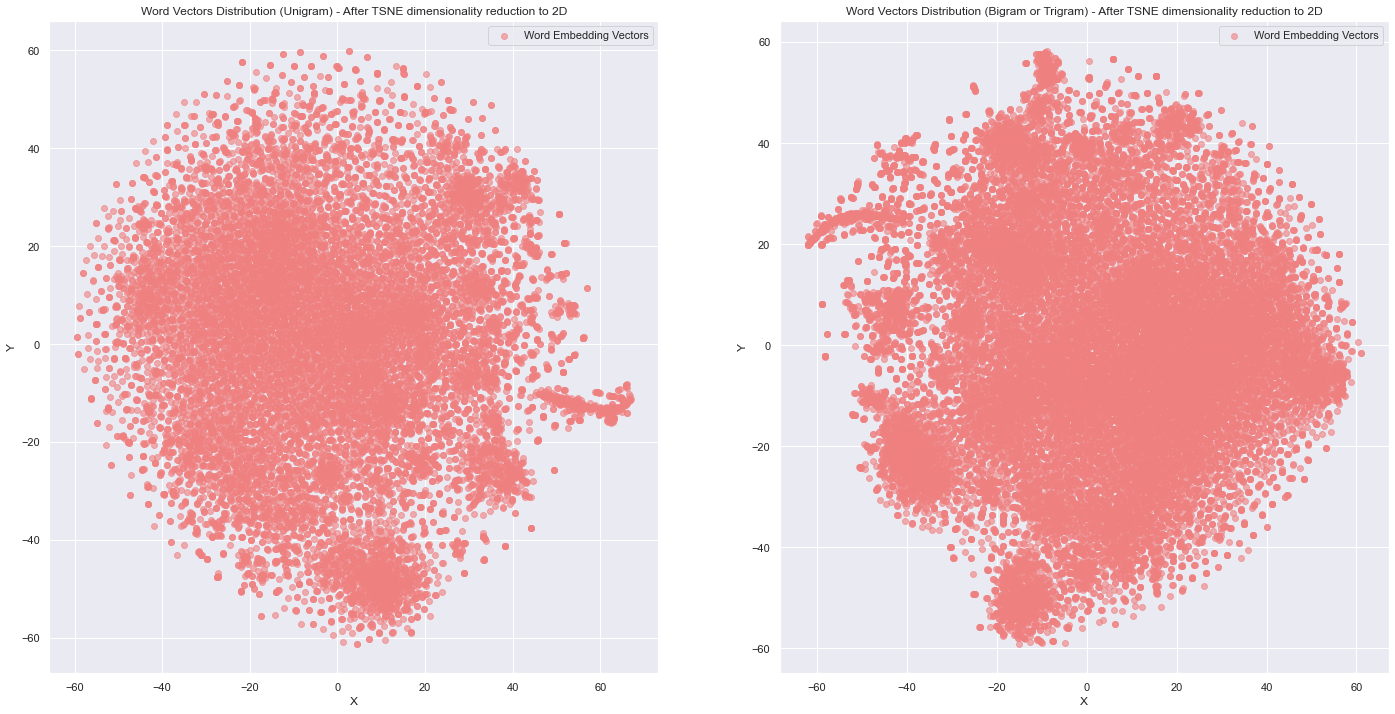

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

fig, axs = plt.subplots(1, 2, figsize=(24, 12))

axs[0].scatter(x_vals, y_vals, color='lightcoral', alpha=0.6, label='Word Embedding Vectors')
axs[0].legend()
axs[0].set_title('Word Vectors Distribution (Unigram) - After TSNE dimensionality reduction to 2D')
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

axs[1].scatter(x_vals_b, y_vals_b, color='lightcoral', alpha=0.6, label='Word Embedding Vectors')
axs[1].legend()
axs[1].set_title('Word Vectors Distribution (Bigram or Trigram) - After TSNE dimensionality reduction to 2D')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.show()

c:\Users\Genis\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_spectral_embedding.py:260: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


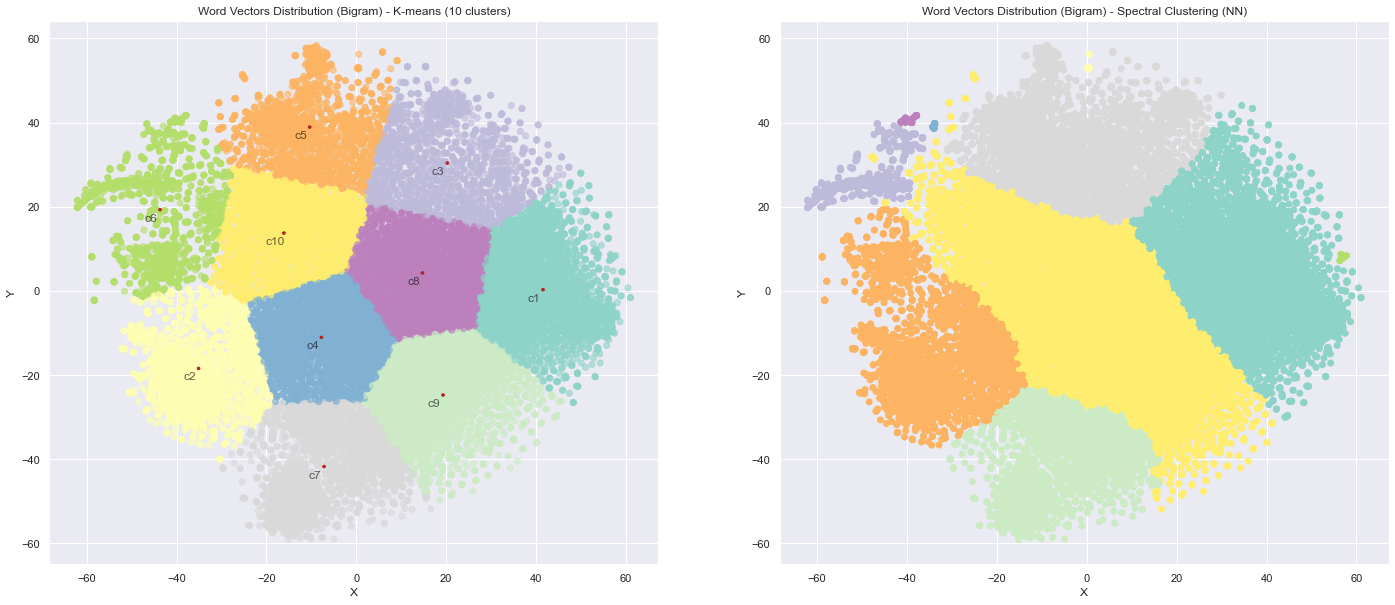

In [6]:
import numpy as np
from dim_reduction_techniques import kmeans_centers, nn_spectral_clustering

k_labels, k_centers = kmeans_centers(x_vals_b, y_vals_b)
spectral_labels = nn_spectral_clustering(x_vals_b, y_vals_b)


# fig, axs = plt.subplots(1, 2, figsize=(18, 6))
fig, axs = plt.subplots(1, 2, figsize=(24, 10))

axs[0].set_title('Word Vectors Distribution (Bigram) - K-means (10 clusters)')
axs[0].scatter(x_vals_b, y_vals_b, c = k_labels, cmap = 'Set3', alpha = 0.6)
axs[0].set_xlabel('X')
axs[0].set_ylabel('Y')

#### Annotate each center with a red dot and the corresponding cluster center
for i, center in enumerate(k_centers):
    axs[0].add_artist(plt.Circle(center, 0.3, color='firebrick', alpha = 1.0, label = 'Cluster Centers'))
    axs[0].annotate(f"c{i+1}", center - 2, ha='center', va='center', color='black', fontsize=12, alpha = 0.6)

axs[1].set_title('Word Vectors Distribution (Bigram) - Spectral Clustering (NN)')
axs[1].scatter(x_vals_b, y_vals_b, c = spectral_labels, cmap = 'Set3')
axs[1].set_xlabel('X')
axs[1].set_ylabel('Y')

plt.show()

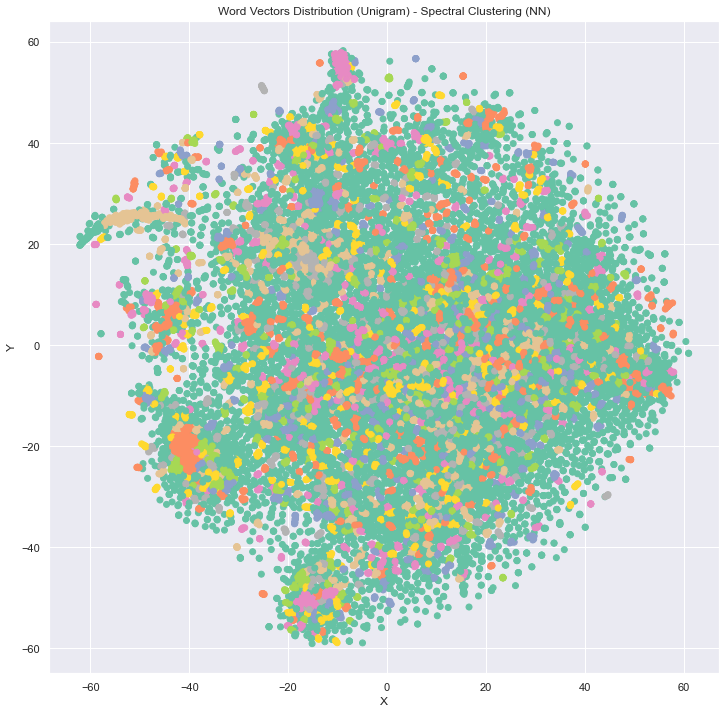

In [8]:
from sklearn.cluster import DBSCAN

dbscan_cluster = DBSCAN(eps = 0.5, min_samples = 5).fit(np.array([x_vals_b, y_vals_b]).T)
dbscan_labels = dbscan_cluster.labels_

plt.figure(figsize = (12, 12))
plt.scatter(x_vals_b, y_vals_b, c = dbscan_labels, cmap = 'Set2')
plt.title('Word Vectors Distribution (Unigram) - Spectral Clustering (NN)')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()